In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd

In [3]:
methods = ["MMD", "MMD OCSVM Verify", "OCSVM"]
model_types = {"kernel=\'linear\'" : "linear", "SVR(":"non-linear", "LinearRegression" : "LReg"}
kernel_colors = {"linear" : "r", "non-linear" : "b", "LReg" : "o", "combined" : "g"}
kernel_alpha = {"linear" : 1/3, "non-linear" : 2/3, "LReg" : "o", "combined" : "g"}
direction_colors = ["r", "b"]
colors = ["bo", "go", "ro", "co", "mo", "yo", "ko"]
direction_markers = [9, 8]
method_markers = {"MMD" : "o" , "OCSVM" : ".", "MMD OCSVM Verify" : ["o", "."]}
marker_meaning = {9 : "forward", 8 : "backwards"}
normalized = {True : "-std", False: ""}
alpha_norm = {True : 1/3, False: 2/3}

In [4]:
def sort_similar_pairs(df):
    n_pairs =  int(df.shape[0]/2)
    
    for pair_index in range(n_pairs):
        pair = df.iloc[pair_index*2].copy()
        backwards_pair =  df.loc[(df.test_node == pair.model_node) & 
                                (df.model_node == pair.test_node)]

        if pair_index*2+1 != backwards_pair.index:
            misplaced_pair = df.loc[pair_index*2+1]
            df.iloc[backwards_pair.index] = misplaced_pair
            df.iloc[pair_index*2+1] = backwards_pair

        if pair.model_node > pair.test_node:
            df.iloc[pair_index*2] = backwards_pair
            df.iloc[pair_index*2+1] = pair

    similar_pairs = [pair for pair in df.values]
    
    return similar_pairs

def get_pair_df(pair, df):
    forward_match = ((df.model_node==pair[0])&(df.test_node==pair[1]))
    backward_match = ((df.model_node==pair[1])&(df.test_node==pair[0]))
    regex_model_types = "|".join(["kernel=\'linear\'", "SVR"])
    model_type_match = (df.model.str.contains(regex_model_types, regex=True))
    forward_df = df.loc[forward_match & model_type_match]
    backward_df = df.loc[backward_match & model_type_match]
    return {str((pair[0], pair[1])) : forward_df, str((pair[1], pair[0])) : backward_df}

def get_linear_non_linear_df(df):
    df_linear = df.loc[df.model.str.contains("kernel=\'linear\'")]
    df_non_linear = pd.concat([df,df_linear]).drop_duplicates(keep=False)
    return df_linear, df_non_linear

In [313]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import numpy as np

def plot_r2_discrpenacy(sample_id, data, omit_bad_pairs=False):
    stats = {}
        
    for experiment in range(1,4):
        with PdfPages(f'results/figures/{sample_id}_experiment_{experiment}.pdf') as pdf:
            print(f"Experiment {experiment}")
            experiment_stats = pd.DataFrame(columns = data.discrepancy.describe().index)
            df = data.loc[(data.experiment==experiment)&(data["sample pair calculation"]==True)]
            unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False))) 
            similar_pairs = sort_similar_pairs(unique_pairs_df)
            pair_dfs = [get_pair_df(pair, df) for pair in similar_pairs[::2]]

            if omit_bad_pairs:
                pair_dfs = [pair_df for pair_df in pair_dfs 
                            if list(pair_df.values())[0].discrepancy.min() < 1 or list(pair_df.values())[1].discrepancy.min() < 1]

            n_pairs = len(pair_dfs)

            xlabel = "Discrepancy"
            ylabel = "Coefficient of Determination"

            for pair_index in range(n_pairs):
                forward_pair, backward_pair = pair_dfs[pair_index].keys()
                forward_df, backward_df = pair_dfs[pair_index].values()
                pair_df = pd.concat([forward_df, backward_df])

                fig, axs = plt.subplots(nrows = 1, ncols = 1, sharey="row", sharex= "row", figsize= (6, 6))
                fig.suptitle(forward_pair, fontsize =13)
                fig.tight_layout(pad=8)

                methods = pd.unique(pair_df.method)
    #             methods = ["MMD"]
                experiment_stats.loc[forward_pair] = forward_df.loc[(forward_df.method==methods[0])].discrepancy.describe().values.T
                experiment_stats.loc[backward_pair] = backward_df.loc[(backward_df.method==methods[0])].discrepancy.describe().values.T
                
                if "MMD OCSVM Verify" in methods:
                    sub_pair_df = pair_df.loc[(pair_df.method == "MMD OCSVM Verify")]
                else:
                    sub_pair_df = pair_df.loc[(pair_df.method == methods[0])]

                for row in sub_pair_df.itertuples(index=False):
                    model_type = [model_types[m] for m in model_types if m in row.model][0]
                    color = kernel_colors[model_type]
                    x, y = round(row.discrepancy,2), round(row.score,2)

                    if row.model_node < row.test_node:
                        direction = 0
                    else:
                        direction = 1 
                    if row.method == "MMD OCSVM Verify":
                        markers = method_markers[row.method]
                        axs.plot(x, y, color, alpha = 1, marker = markers[0])
                        axs.plot(x, y, "w", alpha = 1, marker = markers[1])
                    else:
                        axs.plot(x, y, color, alpha = 1, marker = method_markers[row.method])
                    axs.plot(x, y, color, alpha = 1, marker = direction_markers[direction])

                axs.set_ylabel(ylabel)
                axs.set_xlabel(xlabel)
                axs.set_ylim([0,1.0])
#                 axs.set_xlim([0,1.0])
                
                usability_line = axs.plot([0,1],[0,1],c = "g", linestyle= "--", alpha=0.5)

                d = df[["model_node", "test_node"]].values
                x = d[:,0]
                y = d[:,1]
                kernel_lines = [Line2D(x, y, c= kernel_colors[k], alpha = 2/3, linewidth=5) for k in ["linear","non-linear"]]
                threshold_lines = []
                for method in pd.unique(sub_pair_df.method):
                    marker = method_markers[method]
                    if isinstance(marker, list):
                        threshold_lines.append((Line2D(x, y, c= "b", alpha = 1, marker = marker[0], linewidth = 0),
                                                Line2D(x, y, c= "w", alpha = 1, marker = marker[1], linewidth = 0),
                                                Line2D(x, y, c= "b", alpha = 1, marker = 9, linewidth = 0)))
                        threshold_lines.append((Line2D(x, y, c= "b", alpha = 1, marker = marker[0], linewidth = 0),
                                                Line2D(x, y, c= "w", alpha = 1, marker = marker[1], linewidth = 0),
                                                Line2D(x, y, c= "b", alpha = 1, marker = 8, linewidth = 0)))
                    else:
                        threshold_lines.append((Line2D(x, y, c= "b", alpha = 1, marker = marker, linewidth = 0), 
                                                Line2D(x, y, c= "b", alpha = 1, marker = 9, linewidth = 0)))
                        threshold_lines.append((Line2D(x, y, c= "b", alpha = 1, marker = marker, linewidth = 0), 
                                                Line2D(x, y, c= "b", alpha = 1, marker = 8, linewidth = 0)))

                lines = kernel_lines + usability_line + threshold_lines
                text = ["linear", "non-linear", "usability"]
                
                mean, std, minimum, maximum = experiment_stats.loc[forward_pair][["mean", "std", "min", "max"]]
                forward_statistics_text =f"\nmin={round(minimum,2)} max={round(maximum,2)} \nmean={round(mean,2)} std={round(std,2)}"
                
                mean, std, minimum, maximum = experiment_stats.loc[backward_pair][["mean","std", "min", "max"]]
                backward_statistics_text =f"\nmin={round(minimum,2)} max={round(maximum,2)} \nmean={round(mean,2)} std={round(std,2)}"

                if "MMD OCSVM Verify" in methods:
                    sub_pair_df = pair_df.loc[(pair_df.method != "MMD OCSVM Verify")&
                                              (pair_df["sample pair calculation"]==True)]
                    if method == "MMD OCSVM Verify":
                        mmd_threshold = sub_pair_df.loc[sub_pair_df.method=="MMD"].threshold.values[0]
                        ocsvm_thresholds = pd.unique(sub_pair_df.loc[sub_pair_df.method=="OCSVM"].threshold)
                        if isinstance(ocsvm_thresholds, np.ndarray):
                            text.append(f"forward pair \nMMD({mmd_threshold}) OCSVM({ocsvm_thresholds[0]})" + 
                                        forward_statistics_text)
                            if len(ocsvm_thresholds) > 1:
                                text.append(f"backward pair \nMMD({mmd_threshold}) OCSVM({ocsvm_thresholds[1]})"+ 
                                            backward_statistics_text)
                            else:
                                text.append(f"forward pair \nMMD({mmd_threshold}) OCSVM({ocsvm_thresholds[0]})" + 
                                            forward_statistics_text)
#                         else:
#                             text.append(f"forward pair \nMMD({mmd_threshold}) OCSVM({ocsvm_thresholds})" +
#                                         forward_statistics_text)
#                             text.append(f"backward pair \nMMD({mmd_threshold}) OCSVM({ocsvm_thresholds})" +
#                                         backward_statistics_text)

                elif method in ["MMD", "OCSVM"]:
                    thresholds = sub_pair_df.loc[sub_pair_df.method==method].threshold
                    if method == "MMD":
                        text.append(f"forward pair \nMMD({thresholds.values[0]}))" + forward_statistics_text)
                        text.append(f"backward pair \nMMD({thresholds.values[0]}))" + backward_statistics_text)
                    else:
                        thresholds = pd.unique(thresholds)
                        if isinstance(ocsvm_thresholds, np.ndarray):
                            text.append(f"forward pair \nOCSVM({thresholds[0]}))" + forward_statistics_text)
                            if len(thresholds) > 1:
                                text.append(f"backward pair \nOCSVM({thresholds[1]}))" + backward_statistics_text)
                            else:
                                text.append(f"backward pair \nOCSVM({thresholds[0]}))" + backward_statistics_text)
#                 statistics_text = [forward_statistics_text, backward_statistics_text]
                
                l1 = plt.legend(lines, text, bbox_to_anchor=(0.5, 0.5, 0, 2),
                                loc="center", borderaxespad=0, ncol=1)
                
#                 l2 = plt.legend(threshold_lines, statistics_text, bbox_to_anchor=(1.01,0.5), 
#                                 loc="center left", borderaxespad=0)
                axs.add_artist(l1)
#                 axs.add_artist(l2)
                pdf.savefig(fig)
                plt.show()
        
        stats[experiment] = experiment_stats
    return stats

Experiment 1


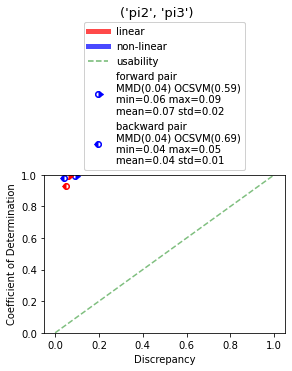

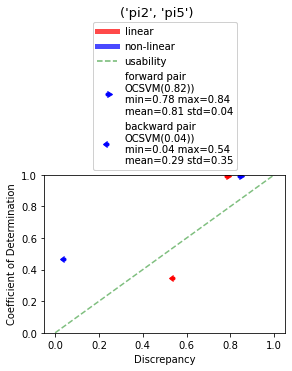

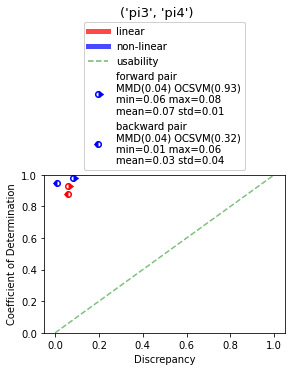

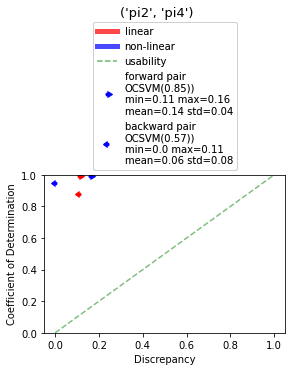

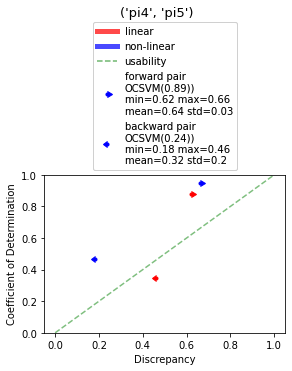

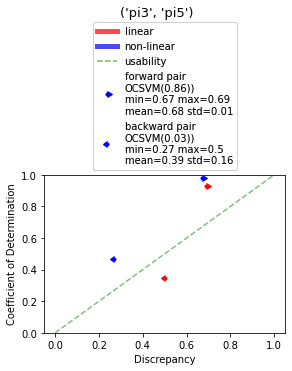

Experiment 2


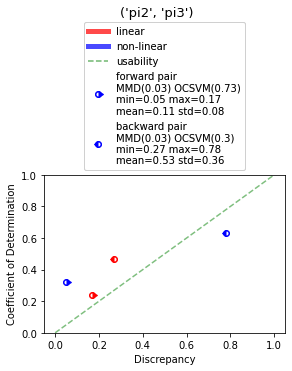

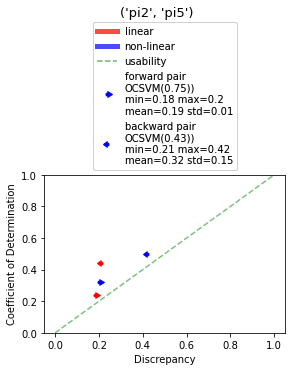

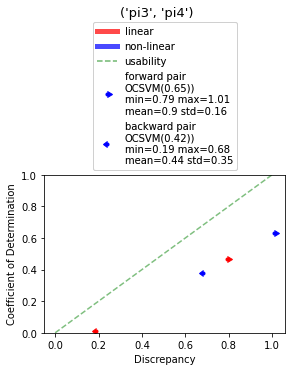

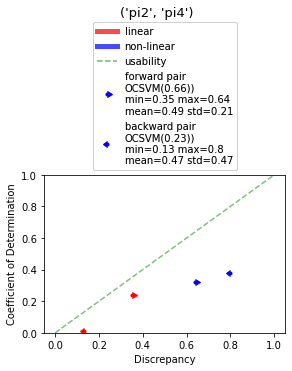

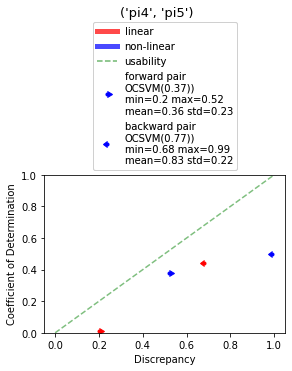

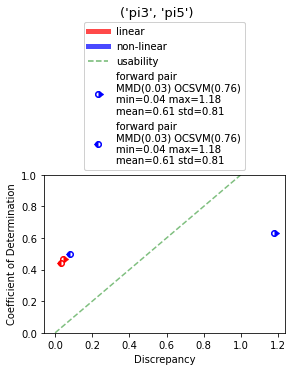

Experiment 3


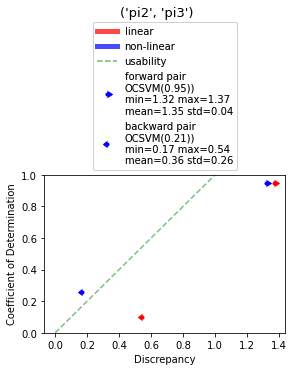

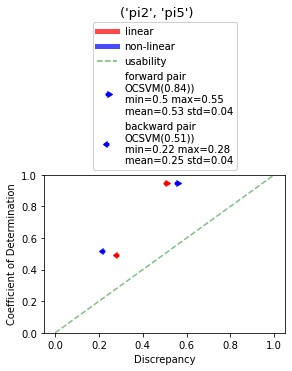

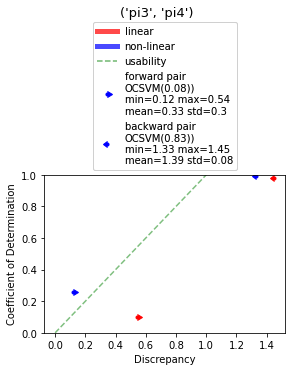

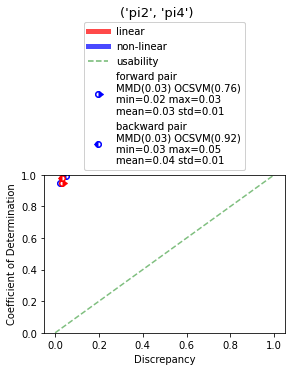

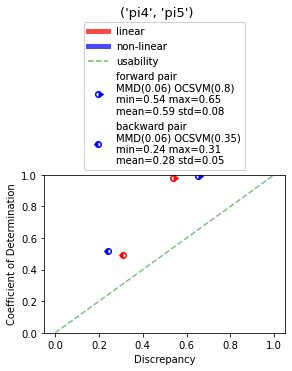

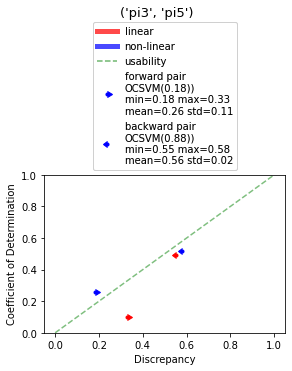

In [321]:
sample_id = f"sample_{3}"
sample_1 = pd.read_csv(f"results/standardised/{sample_id}.csv") 
sample_1_stats = plot_r2_discrpenacy(sample_id, sample_1, omit_bad_pairs=False)

In [373]:
sample_1_stats[1]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi3')",2.0,0.050,0.014142,0.04,0.0450,0.050,0.0550,0.06
"('pi3', 'pi2')",2.0,0.060,0.028284,0.04,0.0500,0.060,0.0700,0.08
"('pi2', 'pi5')",2.0,0.700,0.028284,0.68,0.6900,0.700,0.7100,0.72
"('pi5', 'pi2')",2.0,0.260,0.325269,0.03,0.1450,0.260,0.3750,0.49
"('pi3', 'pi4')",2.0,0.040,0.042426,0.01,0.0250,0.040,0.0550,0.07
"('pi4', 'pi3')",2.0,0.025,0.021213,0.01,0.0175,0.025,0.0325,0.04
"('pi2', 'pi4')",2.0,0.065,0.021213,0.05,0.0575,0.065,0.0725,0.08
"('pi4', 'pi2')",2.0,0.045,0.007071,0.04,0.0425,0.045,0.0475,0.05
"('pi4', 'pi5')",2.0,0.680,0.070711,0.63,0.6550,0.680,0.7050,0.73
"('pi5', 'pi4')",2.0,0.305,0.219203,0.15,0.2275,0.305,0.3825,0.46


In [374]:
sample_1_stats[2]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi3')",2.0,0.135,0.049497,0.10,0.1175,0.135,0.1525,0.17
"('pi3', 'pi2')",2.0,0.285,0.063640,0.24,0.2625,0.285,0.3075,0.33
"('pi2', 'pi5')",2.0,0.155,0.049497,0.12,0.1375,0.155,0.1725,0.19
"('pi5', 'pi2')",2.0,0.190,0.070711,0.14,0.1650,0.190,0.2150,0.24
"('pi3', 'pi4')",2.0,1.120,0.254558,0.94,1.0300,1.120,1.2100,1.30
"('pi4', 'pi3')",2.0,0.305,0.431335,0.00,0.1525,0.305,0.4575,0.61
"('pi2', 'pi4')",2.0,0.575,0.162635,0.46,0.5175,0.575,0.6325,0.69
"('pi4', 'pi2')",2.0,0.365,0.516188,0.00,0.1825,0.365,0.5475,0.73
"('pi4', 'pi5')",2.0,0.265,0.374767,0.00,0.1325,0.265,0.3975,0.53
"('pi5', 'pi4')",2.0,1.000,0.339411,0.76,0.8800,1.000,1.1200,1.24


In [375]:
sample_1_stats[3]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi3')",2.0,1.140,0.084853,1.08,1.1100,1.140,1.1700,1.20
"('pi3', 'pi2')",2.0,0.250,0.282843,0.05,0.1500,0.250,0.3500,0.45
"('pi2', 'pi5')",2.0,0.600,0.098995,0.53,0.5650,0.600,0.6350,0.67
"('pi5', 'pi2')",2.0,0.285,0.077782,0.23,0.2575,0.285,0.3125,0.34
"('pi3', 'pi4')",2.0,0.260,0.296985,0.05,0.1550,0.260,0.3650,0.47
"('pi4', 'pi3')",2.0,1.150,0.028284,1.13,1.1400,1.150,1.1600,1.17
"('pi2', 'pi4')",2.0,0.030,0.000000,0.03,0.0300,0.030,0.0300,0.03
"('pi4', 'pi2')",2.0,0.040,0.014142,0.03,0.0350,0.040,0.0450,0.05
"('pi4', 'pi5')",2.0,0.620,0.070711,0.57,0.5950,0.620,0.6450,0.67
"('pi5', 'pi4')",2.0,0.280,0.127279,0.19,0.2350,0.280,0.3250,0.37


In [11]:
samples = {}
for sample_id in range(1,5):
    sample = pd.read_csv(f"results/original/sample_{sample_id}.csv")
    experiment_data = {}
    for experiment in range(1,4):
        experiment_similar_pairs  = ""
        for method in methods:
            df = sample.loc[(sample.experiment==experiment)&(sample.method==method)&(sample["sample pair calculation"]==True)]
            unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False)))
            similar_pairs = sort_similar_pairs(unique_pairs_df)
            experiment_similar_pairs += str(similar_pairs[::2])
        experiment_data[experiment] = experiment_similar_pairs
    samples[f"sample_{sample_id}"] = experiment_data

In [12]:
samples["sample_1"] == samples["sample_2"] == samples["sample_3"] == samples["sample_4"]       

False

In [43]:
samples["sample_3"][2] == samples["sample_4"][2]

False

In [44]:
samples["sample_1"]

{1: "[array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi5'], dtype=object), array(['pi3', 'pi4'], dtype=object)]",
 2: "[array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi4'], dtype=object), array(['pi2', 'pi5'], dtype=object), array(['pi4', 'pi5'], dtype=object), array(['pi3', 'pi5'], dtype=object)]",
 3: "[array(['pi2', 'pi4'], dtype=object), array(['pi4', 'pi5'], dtype=object)][array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object)]"}

In [46]:
samples["sample_4"]

{1: "[array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi5'], dtype=object), array(['pi3', 'pi4'], dtype=object), array(['pi4', 'pi5'], dtype=object)]",
 2: "[array(['pi3', 'pi5'], dtype=object)][array(['pi3', 'pi5'], dtype=object)][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi4'], dtype=object), array(['pi2', 'pi5'], dtype=object), array(['pi4', 'pi5'], dtype=object), array(['pi3', 'pi5'], dtype=object)]",
 3: "[array(['pi2', 'pi4'], dtype=object), array(['pi2', 'pi5'], dtype=object), array(['pi4', 'pi5'], dtype=object)][array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi4'], dtype=object)]"}

In [45]:
samples["sample_3"] 

{1: "[array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi5'], dtype=object), array(['pi3', 'pi4'], dtype=object)]",
 2: "[array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi5'], dtype=object)][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi5'], dtype=object)][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi4'], dtype=object), array(['pi2', 'pi5'], dtype=object), array(['pi4', 'pi5'], dtype=object), array(['pi3', 'pi5'], dtype=object)]",
 3: "[array(['pi2', 'pi4'], dtype=object), array(['pi2', 'pi5'], dtype=object), array(['pi4', 'pi5'], dtype=object)][][array(['pi3', 'pi4'], dtype=object)]"}

In [ ]:
== samples["sample_4"]  